In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from tifffile import imread

147128it [00:00, 172483.11it/s]
C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)


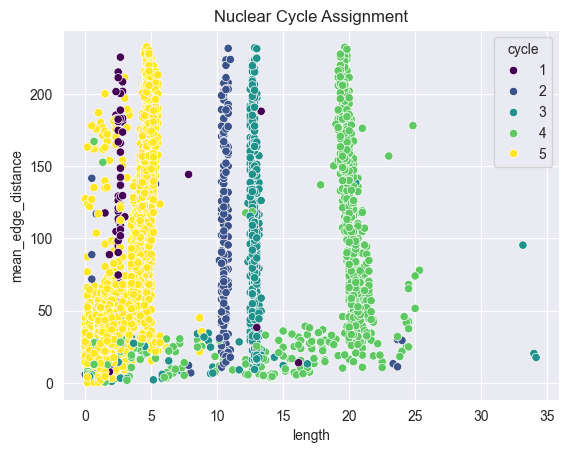

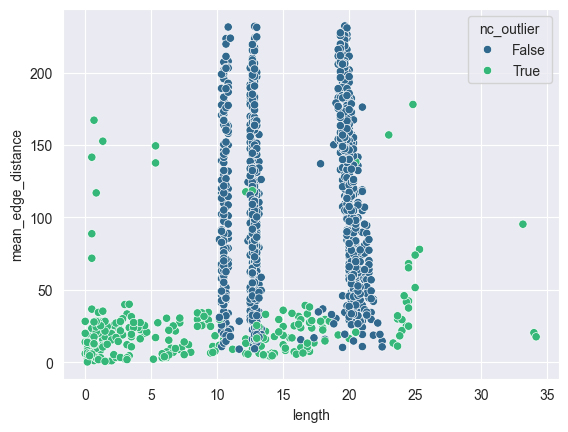

In [3]:
from src.utils import tracklet_from_path, ap_axis_position, detect_nuclear_cycle, get_tracklet_tree, sister_tracklets
from scipy.stats import beta, pearsonr

root = "embryo016"
datapath = Path.cwd().parent / "data"
tracking_path = datapath / "interim" / "tracking" / root
results_path = Path.cwd().parent / "results" / "lineages" / root

spots, edges, tracks, tracklets = tracklet_from_path(tracking_path, root, t_delta=1/6)
color_img = imread(tracking_path /  f"{root}_vis.tif")
label_img = imread(tracking_path /  f"{root}_label_img.tif")

### Confirm Movie-Specific Parameters
# anterior-posterior axis endpoints 
x_a, y_a = 106, 334
x_p, y_p = 1320, 898

n_divisions = 4

spots, tracklets = ap_axis_position(spots, tracklets, (x_a, y_a), (x_p, y_p))
peaks, tracklets = detect_nuclear_cycle(tracklets, n_divisions + 1)
tracklets["nuclear_cycle"] = tracklets["cycle"] + 9

# show nuclear cycle assignment
sns.scatterplot(tracklets, x="length", y="mean_edge_distance", hue="cycle", palette="viridis")
plt.title("Nuclear Cycle Assignment")
plt.savefig(results_path / "nuclear_cycle_assignment.png")
plt.show()

focused_nc = tracklets[tracklets["cycle"].between(2, 4)]
sns.scatterplot(focused_nc, x="length", y="mean_edge_distance", hue="nc_outlier", palette="viridis")
plt.show()
# show nuclear cycle outliers
# sns.scatterplot(tracklets, x="start_time", y="end_time", hue="nc_outlier", palette="viridis")
# plt.title("Nuclear Cycle Outliers")
# 
# plt.savefig(results_path / "labeled_outlier.png")
# plt.show()
# 
# tracklets = sister_tracklets(tracklets)

spots["label_img_id"] = label_img[spots["FRAME"], spots["POSITION_Y"].astype(int), spots["POSITION_X"].astype(int)]

def jitter(values, amt=0.05):
    return values + np.random.normal(0,amt,values.shape)

In [4]:
normal_nc = tracklets[tracklets["mean_edge_distance"] > 50]
normal_nc = normal_nc[normal_nc["cycle"].between(2, 4)]
normal_nc = normal_nc[normal_nc["nc_outlier"] == False]


NC NC 11 residual_ratio: 0.010466817422857837
NC NC 11 mean length: 10.571625344352617
NC NC 11 variance ratio: 0.01676219515024358
NC NC 12 residual_ratio: 0.011648214013262208
NC NC 12 mean length: 12.780172413793103
NC NC 12 variance ratio: 0.014367869709538555
NC NC 13 residual_ratio: 0.016633969391277478
NC NC 13 mean length: 20.026041666666664
NC NC 13 variance ratio: 0.02468682830214256


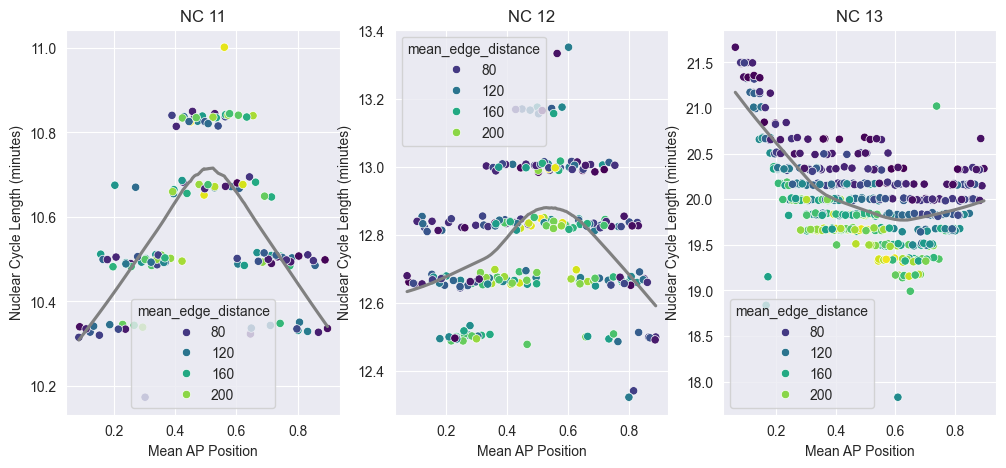

In [14]:
from statsmodels.nonparametric.smoothers_lowess import lowess
# visualize ap dependence on nuclear cycle length
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for i, (nc, color, ax) in enumerate(zip(["NC 11", "NC 12", "NC 13"], ["blue", "green", "red"], axes.flatten()), start=2):
    norm_cyc = normal_nc[normal_nc["cycle"]==i]
    
    sns.scatterplot(x=norm_cyc["mean_ap_position"], y=jitter(norm_cyc["length"], 0.01), hue=norm_cyc["mean_edge_distance"], palette="viridis", ax=ax)
    sns.regplot(x=norm_cyc["mean_ap_position"], y=norm_cyc["length"], scatter=False, ax=ax, color="gray", lowess=True)
    ax.set_title(nc)
    ax.set_xlabel("Mean AP Position")
    ax.set_ylabel("Nuclear Cycle Length (minutes)")
    
    y_pred = lowess(norm_cyc["length"], norm_cyc["mean_ap_position"], frac=0.5, return_sorted=False)
    print(f"NC {nc} residual_ratio: {np.std(norm_cyc['length'] - y_pred) / np.mean(norm_cyc['length'])}")
    
    from_edge = norm_cyc
    # from_edge = norm_cyc[norm_cyc["mean_edge_distance"] > 50]
    
    print(f"NC {nc} mean length: {from_edge['length'].mean()}")
    print(f"NC {nc} variance ratio: {from_edge['length'].std() / from_edge['length'].mean()}")

plt.savefig(results_path / f"nuclear_cycle_length_ap_regression.png")

NC NC 11 mean length: 10.571625344352617
NC NC 11 variance ratio: 0.01676219515024358
NC NC 12 mean length: 12.780172413793103
NC NC 12 variance ratio: 0.014367869709538555
NC NC 13 mean length: 20.026041666666664
NC NC 13 variance ratio: 0.02468682830214256


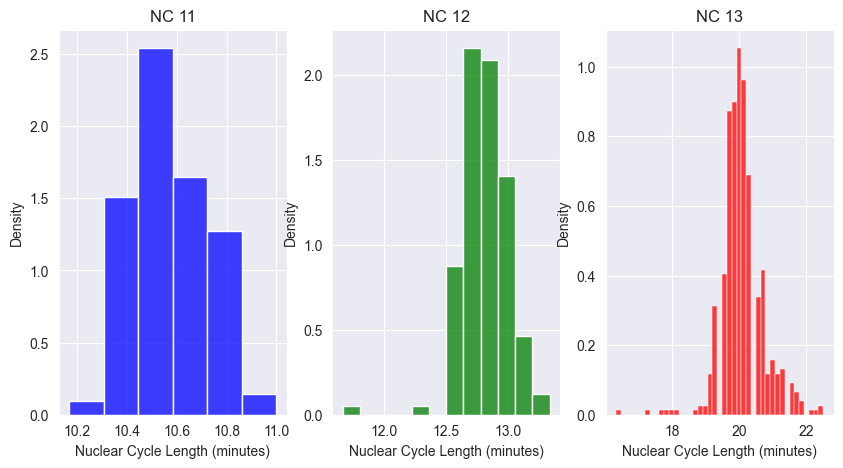

In [6]:
# visualize nuclear cycle length

normal_tracklets = tracklets[tracklets["nc_outlier"] == False]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

for i, (nc, color, ax) in enumerate(zip(["NC 11", "NC 12", "NC 13"], ["blue", "green", "red"], axes.flatten()), start=2):
    norm_cyc = normal_tracklets[normal_tracklets["cycle"]==i]
    
    sns.histplot(norm_cyc, x="length", stat="density", color=color, ax=ax, binwidth=1/7)
    ax.set_title(nc)
    ax.set_xlabel("Nuclear Cycle Length (minutes)")
    ax.set_ylabel("Density")
    
    # from_edge = norm_cyc
    from_edge = norm_cyc[norm_cyc["mean_edge_distance"] > 50]
    
    print(f"NC {nc} mean length: {from_edge['length'].mean()}")
    print(f"NC {nc} variance ratio: {from_edge['length'].std() / from_edge['length'].mean()}")
    
plt.savefig(results_path / f"nuclear_cycle_length.png")
plt.show()

KeyError: 'division_angle_difference'

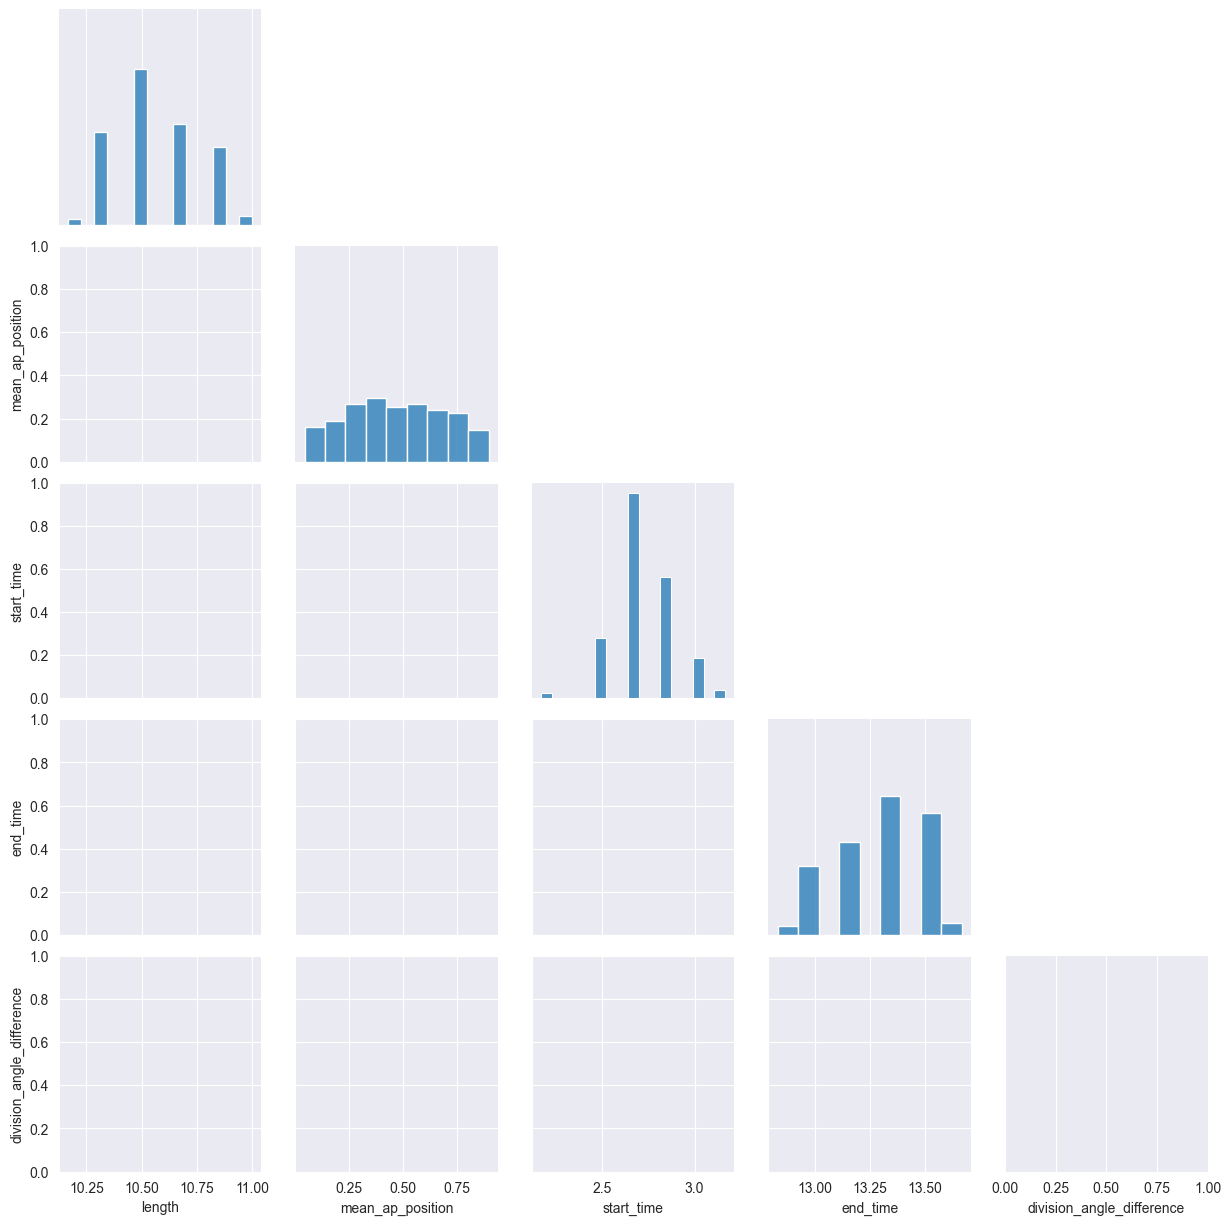

In [7]:
# fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, (nc_lab, color) in enumerate(zip(["NC 11", "NC 12", "NC 13"], ["blue", "green", "red"]), start=2):
    nc = normal_tracklets[normal_tracklets["cycle"]==i]
    g = sns.pairplot(nc, vars=["length", "mean_ap_position", "start_time", "end_time", "division_angle_difference"], corner=True)
    g.map_lower(sns.kdeplot, levels=4, color=".2")
    plt.suptitle(f"{nc_lab}")
    plt.savefig(results_path / f"{nc_lab}_pairplot.png")
    plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for k, ax, nc, color in zip(range(2, 5), axes, ["NC 11", "NC 12", "NC 13"], ["blue", "green", "red"]):
    sns.histplot(tracklets[tracklets["cycle"]==k], x="division_angle_difference", stat="density", color="blue", ax=ax)
    a, b, loc, scale = beta.fit(np.array(tracklets[tracklets["cycle"]==k]["division_angle_difference"].dropna().to_numpy(), dtype=np.float16))
    
    x = np.linspace(0, np.pi/2, 100, endpoint=False)
    # ax.plot(x, beta.pdf(x, a, b, loc, scale), color=color)
    
    ax.set_title(nc)

fig.suptitle("Parent vs. Daughter Division Angle Difference")
plt.show()

In [ ]:

from skimage.morphology import convex_hull_image
from scipy.spatial.distance import cdist
from PIL import Image

# visualize nuclei domains

# frame of interest
k = 300

# get convex hull of label image
convex_hull = convex_hull_image(label_img[k])
print(convex_hull.shape)

# get nearest centroid in spots to each pixel
centroids = spots[spots["FRAME"] == k][["POSITION_Y", "POSITION_X"]].values
centroids.put(0, np.array([0, 0]))
yx = np.meshgrid(np.arange(label_img.shape[1]), np.arange(label_img.shape[2]))
yx = np.stack([yx[1].flatten(), yx[0].flatten()], axis=1)

nearest_centroid = np.argmin(cdist(yx, centroids), axis=1).reshape(label_img.shape[1], label_img.shape[2])*convex_hull

# map label image centroid id to color image color
cmap = np.array([color_img[k][*centroid] for centroid in np.array(centroids, dtype=int)])

color_centroids = cmap[np.array(nearest_centroid, dtype=int)]

# create an image with the color centroids
color_centroids_img = Image.fromarray(color_centroids)
color_centroids_img.save(results_path / "color_centroids.png")

In [ ]:
print("spots", spots.columns)
print("edges", edges.columns)
print("tracks", tracks.columns)
print("tracklets", tracklets.columns)

# sns.histplot(tracklets, x="start", y="length", palette="viridis")
# sns.kdeplot(tracklets, x="start", y="length", levels=5, fill=True)

normal_start = tracklets[np.abs(tracklets["cycle_start_deviation"]) < 2.0]

early_end = normal_start[normal_start["cycle_end_deviation"] < 2.0]
late_end = normal_start[normal_start["cycle_end_deviation"] > 2.0]

# sns.scatterplot(x=jitter(late_end.cycle), y=jitter(late_end["cycle_end_deviation"], 0.5), hue=late_end.cycle, palette="viridis")

# plt.title("tracklet assigned cycle")

sns.histplot(tracklets, x="start_time", hue="cycle", palette="viridis")

plt.title("Tracklet cycle assignment")
plt.xlabel("Time (minutes)")
plt.savefig(results_path / "tracklet_cycle_assignment.png")
plt.show()

In [ ]:
# visualize a single lineage tree
track = spots[spots["TRACK_ID"] == spots["TRACK_ID"].unique()[6]]
track = track.sort_values(by="FRAME")
distance_from_origin = np.sqrt((track["POSITION_X"] - track["POSITION_X"].iloc[0])**2 + (track["POSITION_Y"] - track["POSITION_Y"].iloc[0])**2)

plt.scatter(track["time"], distance_from_origin, c=track["TRACKLET_ID"])

plt.xlabel("Time (minutes)")
plt.ylabel("Distance from lineage origin (pixels)")

plt.savefig(results_path / "lineage_distance_from_origin.png")

plt.show()

In [ ]:
from src.utils import get_tracklet_tree, visualize_tracklet_tree

def plot_tracklet_trees(track_ids,  fig, axes):
    for track_id,  ax in zip(track_ids, axes.flatten()):
        tree = get_tracklet_tree(tracklets[tracklets["track_id"] == track_id])
        
        # get track color
        spot = spots[spots["TRACK_ID"] == track_id]
        spot_x, spot_y, spot_frame = spot["POSITION_X"].iloc[0], spot["POSITION_Y"].iloc[0], spot["FRAME"].iloc[0]
       
        color = color_img[int(spot_frame)][int(spot_y)][int(spot_x)]
        color_rgb = f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}"
        
        label = label_img[spot_frame][int(spot_y)][int(spot_x)]
        
        # ax.set_title(f"track {track_id}, label {label}")
        ax.set_facecolor("w")
            
        visualize_tracklet_tree(tree, ax, c=color_rgb)
    
    fig.supxlabel("Time (minutes)")
    
    return fig, axes

### manually selected trees
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex="all", sharey="all")

# map label_img_id to track_id
label_img_id = spots.groupby("TRACK_ID")["label_img_id"].first()
label_img_id = label_img_id[label_img_id != 0]


# trees_of_interest_001 = [84, 96, 66, 115, 102, 134, 38, 24, 19, 43, 116, 41, 14, 31, 37, 50, 62, 42, 39, 36, 93, 76, 47, 73, 89, 106, 82, ]
# trees_of_interest = [60, 64, 83, 73, 86, 97, 109, 98, 6, 26, 37, 24, 19, 80, 52, 38]
# 
# track_id = [label_img_id[label_img_id == k].index[0] for k in trees_of_interest]
# print(track_id)
# 
# fig, axes = plot_tracklet_trees(track_id, fig, axes)
# 
# plt.savefig(results_path / "tracklet_trees_of_interest.png")
# plt.show()

In [ ]:
### Trees with 4-6 splits
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex="all", sharey="all")

split_track_ids = tracks[tracks["NUMBER_SPLITS"].between(14, 16)]["TRACK_ID"].sample(9)

print(split_track_ids)

fig, axes = plot_tracklet_trees(split_track_ids, fig, axes)

plt.savefig(results_path / "tracklet_short_trees.png")
plt.show()

In [ ]:
from scipy.spatial import ConvexHull




## Area Measurements

In [ ]:
# visualize the area of spots over time

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(data=spots, x="time", y="AREA", ax=ax, errorbar="sd")
plt.ylabel("Area (pixels)")
plt.xlabel("Time (minutes)")
plt.title("Detected nucleus Area Over Time")
plt.savefig(results_path / "nucleus_area.png")
plt.show()

In [ ]:
normal_tracklets = tracklets[tracklets["nc_outlier"] == False]

spots["frame_from_start"] = spots["FRAME"] - spots.groupby("TRACKLET_ID")["FRAME"].transform("min")
spots["time_from_start"] = spots["frame_from_start"] * 1/6

fig, axes = plt.subplots(3, 1, figsize=(5, 8), sharex=True)

# visualize area of spots over time aligned by the start of nuclear cycle
for i, ax in enumerate(axes, start=2):
    sns.lineplot(data=spots[spots["TRACKLET_ID"].isin(normal_tracklets[normal_tracklets["cycle"]==i].index)], x="time_from_start", y="AREA", ax=ax)
    ax.set_ylabel("Area (pixels)")
    ax.set_xlabel("")
    ax.set_title(f"NC {i + 9}")
plt.xlabel("Time (minutes)")
plt.savefig(results_path / f"nucleus_area_by_nc_aligned.png")
plt.show()

In [ ]:
normal_tracklets = tracklets[tracklets["nc_outlier"] == False]

spots["frame_from_start"] = spots["FRAME"] - spots.groupby("TRACKLET_ID")["FRAME"].transform("min")
spots["time_from_start"] = spots["frame_from_start"] * 1/6

# visualize area of spots over time aligned by the start of nuclear cycle
for i in range(2, 5):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.lineplot(data=spots[spots["TRACKLET_ID"].isin(normal_tracklets[normal_tracklets["cycle"]==i].index)], x="time_from_start", y="AREA", ax=ax)
    plt.ylabel("Area (pixels)")
    plt.xlabel("Time (minutes)")
    plt.title(f"Detected nucleus area over time, NC {i + 9}")
    plt.savefig(results_path / f"nucleus_area_nc_{i}.png")
    plt.show()

In [ ]:
sns.histplot(spots, x="AREA", stat="density", kde=True)
sns.histplot(x=spots.groupby("TRACKLET_ID")["AREA"].transform("max"), stat="density", kde=True)

In [ ]:
tracklets["max_spot_area"] = spots.groupby("TRACKLET_ID")["AREA"].mean()
normal_nc = tracklets[tracklets["nc_outlier"] == False]
normal_nc = normal_nc[normal_nc["cycle"].between(2, 4)]
sns.kdeplot(normal_nc, x="max_spot_area", hue="nuclear_cycle", fill=True, common_norm=False)
plt.xlabel("Max Spot Area (pixels)")
plt.savefig(results_path / "max_spot_area_kde.png")
plt.show()